In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 MB 81.0 MB/s  0:00:01 eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Pricing Data Loading and Analysis

In [4]:
df = pd.read_csv('https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_pricing_project.csv')

print(df.shape)
df.head()

(4843, 15)


,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 4843 non-null   int64 
 1   model_key                  4843 non-null   object
 2   mileage                    4843 non-null   int64 
 3   engine_power               4843 non-null   int64 
 4   fuel                       4843 non-null   object
 5   paint_color                4843 non-null   object
 6   car_type                   4843 non-null   object
 7   private_parking_available  4843 non-null   bool  
 8   has_gps                    4843 non-null   bool  
 9   has_air_conditioning       4843 non-null   bool  
 10  automatic_car              4843 non-null   bool  
 11  has_getaround_connect      4843 non-null   bool  
 12  has_speed_regulator        4843 non-null   bool  
 13  winter_tires               4843 non-null   bool  
 14  rental_p

In [6]:
print("=== MISSING VALUES ===")
print(df.isnull().sum())
print()

print("=== TARGET STATS ===")
print(df['rental_price_per_day'].describe())

print()
print("=== CATEGORICAL COLUMNS ===")
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col} : {df[col].nunique()} unique values")
    print(df[col].value_counts().head(5))

=== MISSING VALUES ===
Unnamed: 0                   0
model_key                    0
mileage                      0
engine_power                 0
fuel                         0
paint_color                  0
car_type                     0
private_parking_available    0
has_gps                      0
has_air_conditioning         0
automatic_car                0
has_getaround_connect        0
has_speed_regulator          0
winter_tires                 0
rental_price_per_day         0
dtype: int64

=== TARGET STATS ===
count    4843.000000
mean      121.214536
std        33.568268
min        10.000000
25%       104.000000
50%       119.000000
75%       136.000000
max       422.000000
Name: rental_price_per_day, dtype: float64

=== CATEGORICAL COLUMNS ===

model_key : 28 unique values
model_key
Citroën    969
Renault    916
BMW        827
Peugeot    642
Audi       526
Name: count, dtype: int64

fuel : 4 unique values
fuel
diesel           4641
petrol            191
hybrid_petrol       8
e

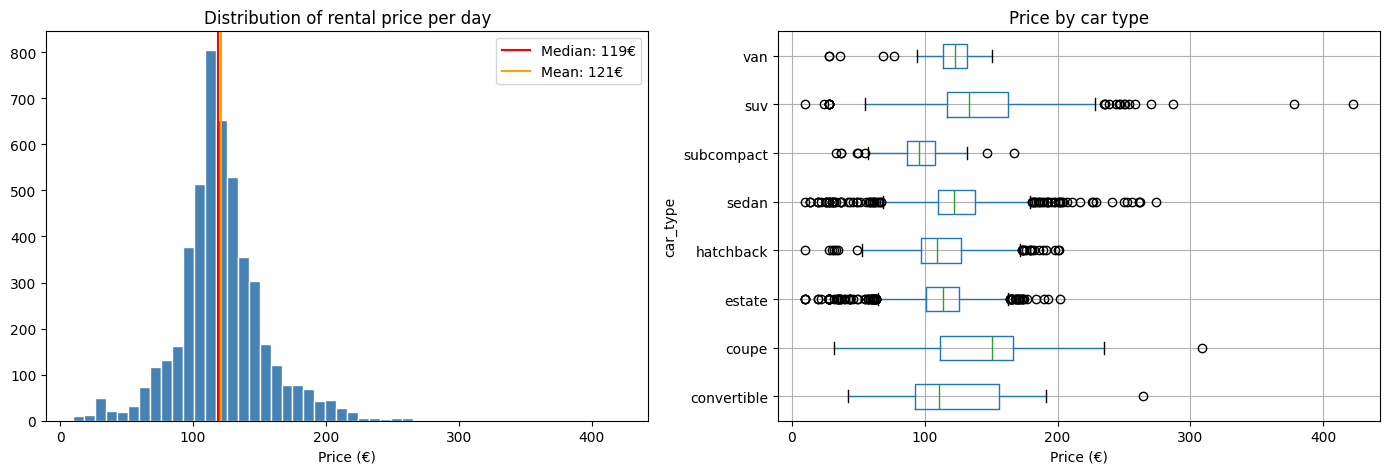

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price distribution
axes[0].hist(df['rental_price_per_day'], bins=50, color='steelblue', edgecolor='white')
axes[0].axvline(df['rental_price_per_day'].median(), color='red', label=f"Median: {df['rental_price_per_day'].median():.0f}€")
axes[0].axvline(df['rental_price_per_day'].mean(), color='orange', label=f"Mean: {df['rental_price_per_day'].mean():.0f}€")
axes[0].set_title('Distribution of rental price per day')
axes[0].set_xlabel('Price (€)')
axes[0].legend()

# Boxplot by vehicle type
df.boxplot(column='rental_price_per_day', by='car_type', ax=axes[1], vert=False)
axes[1].set_title('Price by car type')
axes[1].set_xlabel('Price (€)')
plt.suptitle('')
plt.tight_layout()
plt.show()

=== CORRELATION WITH TARGET ===
rental_price_per_day    1.000000
engine_power            0.625645
Unnamed: 0              0.246809
mileage                -0.448912
Name: rental_price_per_day, dtype: float64


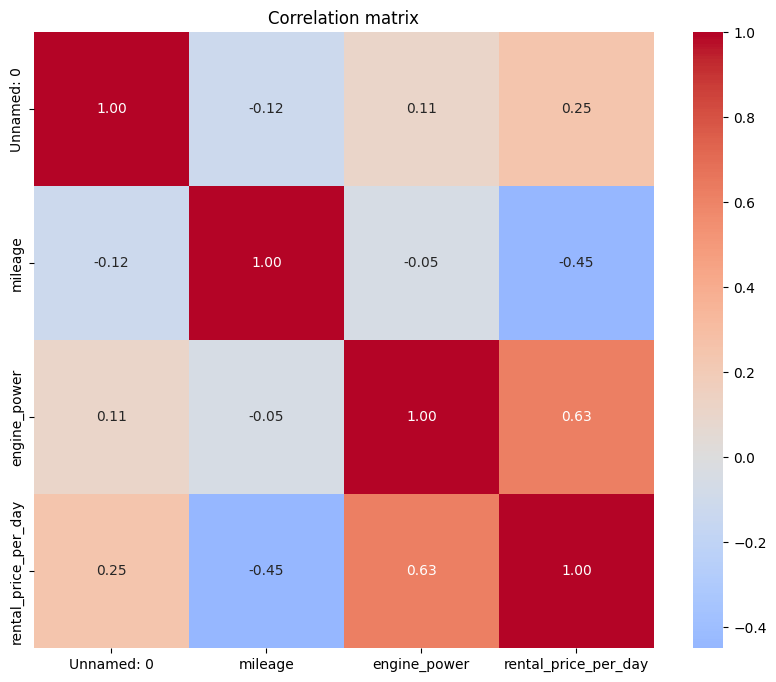

In [9]:
# Correlation of numeric variables with price
numeric_cols = df.select_dtypes(include='number').columns
corr = df[numeric_cols].corr()['rental_price_per_day'].sort_values(ascending=False)
print("=== CORRELATION WITH TARGET ===")
print(corr)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation matrix')
plt.show()

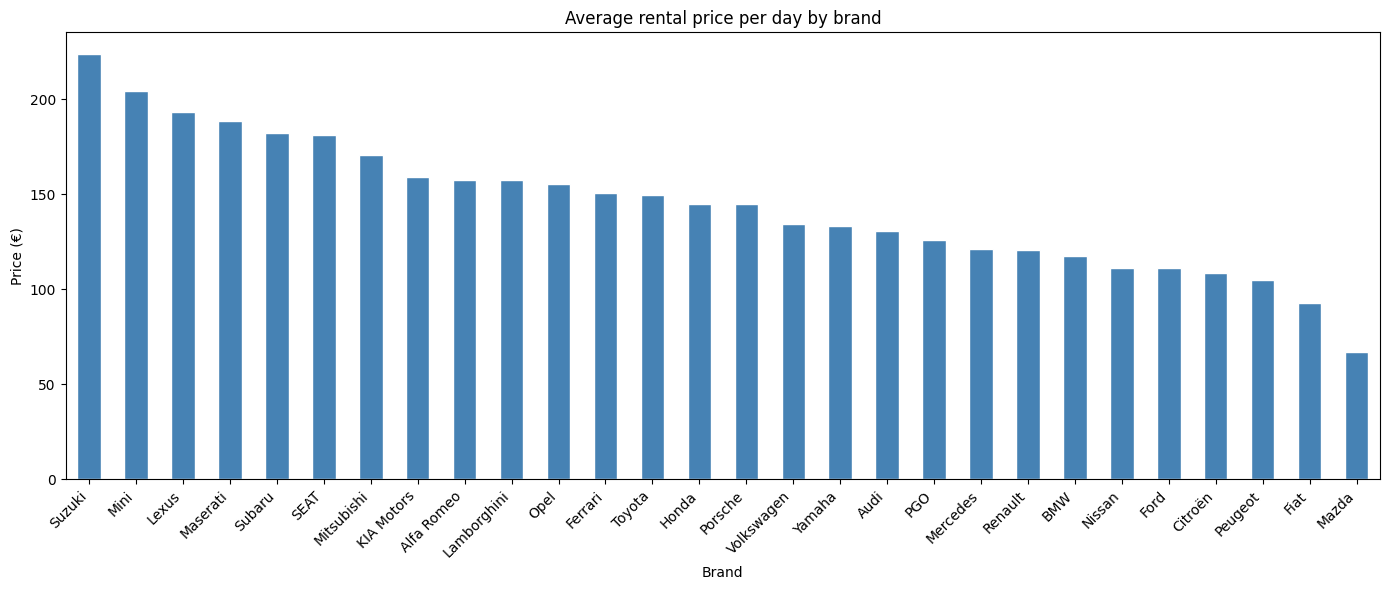

In [10]:
brand_prices = df.groupby('model_key')['rental_price_per_day'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
brand_prices.plot(kind='bar', color='steelblue', edgecolor='white')
plt.title('Average rental price per day by brand')
plt.ylabel('Price (€)')
plt.xlabel('Brand')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
# Drop the index column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Features and target
X = df.drop('rental_price_per_day', axis=1)
y = df['rental_price_per_day']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()
bool_features = X.select_dtypes(include='bool').columns.tolist()

# Booleans → treated as numeric
numeric_features = numeric_features + bool_features

print(f"\nNumeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

Features shape: (4843, 13)
Target shape: (4843,)

Numeric features: ['mileage', 'engine_power', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']
Categorical features: ['model_key', 'fuel', 'paint_color', 'car_type']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (3874, 13)
Test set: (969, 13)


In [13]:
# Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [16]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results = {}

for name, model in models.items():
    # Complete pipeline: preprocessing + model
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
    print(f"{name:20s} → RMSE: {rmse:.2f} | MAE: {mae:.2f} | R²: {r2:.3f}")

# Comparative tabledf_results = pd.DataFrame(results).T.sort_values('RMSE')
print("\n=== RANKING (best → worst) ===")
df_results = pd.DataFrame(results).T.sort_values('RMSE')
print(df_results)

Ridge                → RMSE: 17.97 | MAE: 12.12 | R²: 0.693
RandomForest         → RMSE: 16.75 | MAE: 10.69 | R²: 0.734
GradientBoosting     → RMSE: 17.03 | MAE: 11.37 | R²: 0.725
XGBoost              → RMSE: 16.60 | MAE: 10.50 | R²: 0.738

=== RANKING (best → worst) ===
                       RMSE        MAE        R²
XGBoost           16.602762  10.496041  0.738278
RandomForest      16.753114  10.694613  0.733516
GradientBoosting  17.031475  11.370657  0.724587
Ridge             17.968919  12.119205  0.693435


In [17]:
# Select the best one (usually XGBoost or RandomForest)
# Adjust the name if your best model is different
best_model_name = df_results.index[0]  # Le premier = meilleur RMSE
print(f"Best model: {best_model_name}")

# Rebuilds the final pipeline with the best model
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', models[best_model_name])
])

final_pipeline.fit(X_train, y_train)

# Backing up the entire pipeline (preprocessor + model together)
import os
os.makedirs('../api', exist_ok=True)

joblib.dump(final_pipeline, '../api/pipeline.pkl')
print("✅ Pipeline saved to ../api/pipeline.pkl")

# Also saves column names (important for the API)
import json
feature_names = X.columns.tolist()
with open('../api/feature_names.json', 'w') as f:
    json.dump(feature_names, f)
print("✅ Feature names saved to ../api/feature_names.json")

Best model: XGBoost
✅ Pipeline saved to ../api/pipeline.pkl
✅ Feature names saved to ../api/feature_names.json
